# Codigo PyMongo y Python 

## Dataset Spotify
### Autor: Francisco Guasumba
### 

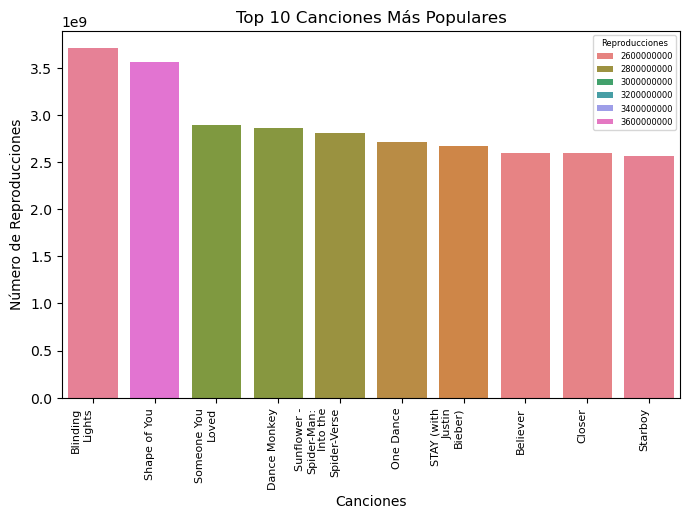

In [59]:
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap 
import pandas as pd

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["Spotify"]
collection = db["Spotify"]

# Consulta para obtener las canciones más populares
top_songs = list(collection.find().sort("streams", pymongo.DESCENDING).limit(10))
#print(top_songs)
# Extraer
canciones = [song["track_name"] for song in top_songs]
reproducciones = [song["streams"] for song in top_songs]
artista=[song["artist(s)_name"] for song in top_songs]

# Grafico
plt.figure(figsize=(7,7))
ax=sns.barplot(x= canciones,y=reproducciones, hue=reproducciones,  palette="husl")
plt.ylabel('Número de Reproducciones')
plt.xlabel('Canciones')
plt.title('Top 10 Canciones Más Populares')
plt.xticks(rotation=90, ha='right', fontsize=8) 
plt.tight_layout()
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([textwrap.fill(label, width=12) for label in canciones])
ax.legend(fontsize='6', title="Reproducciones",title_fontsize='6')
plt.show()


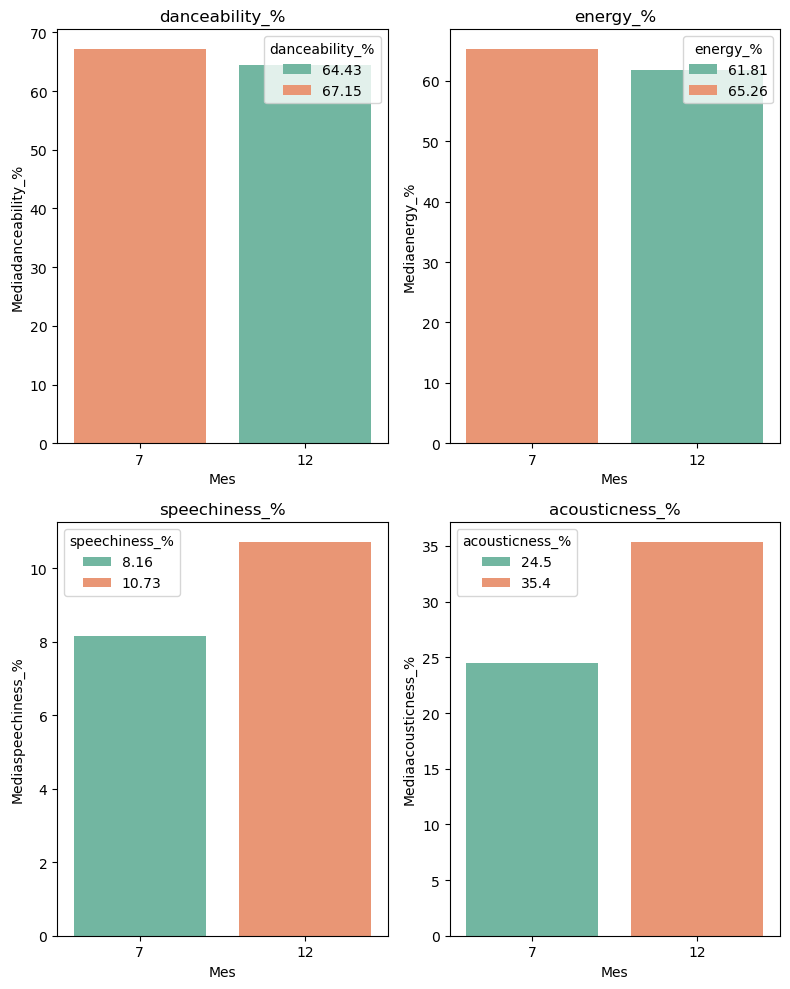

In [102]:

# Obtener canciones lanzadas en julio y diciembre
canciones_jul_dic = collection.find(
  {
    "$or": [
      { "released_month": 7 },
      { "released_month": 12 }
    ]
  },
  {
    "_id": 0,"released_month": 1,"danceability_%": 1,"energy_%": 1,"speechiness_%": 1,"acousticness_%": 1
  }
)


df = pd.DataFrame(list(canciones_jul_dic))
# Calcular la media de las métricas para julio y diciembre
media_metricas = df.groupby("released_month").mean().round(2).reset_index()
#print(media_metricas)
#  gráfico

fig, axes = plt.subplots(2, 2, figsize=(8, 10))
for i, metrica in enumerate(["danceability_%", "energy_%", "speechiness_%", "acousticness_%"]):
    sns.barplot(x="released_month",y=metrica,hue=metrica,data=media_metricas, ax=axes[i // 2, i % 2] , palette="Set2"  )
    axes[i // 2, i % 2].set_ylabel(f'Media{metrica}')
    axes[i // 2, i % 2].set_xlabel('Mes')
    axes[i // 2, i % 2].set_title(metrica)
    ax.legend(fontsize='6', title="Reproducciones",title_fontsize='4')

plt.tight_layout()
plt.show()

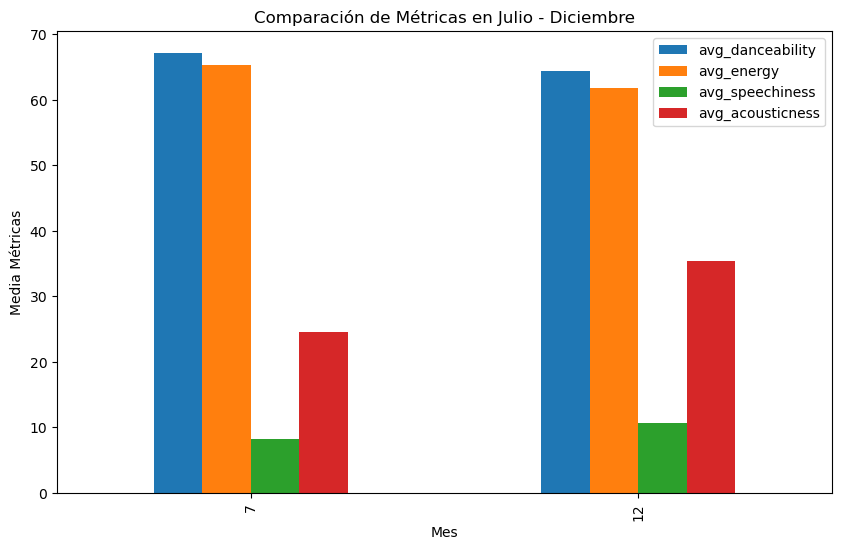

In [105]:
#Comparacion Julio Diciembre
consulta = collection.aggregate([
    {
        "$match": {
            "$or": [
                { "released_month": 7 },
                { "released_month": 12 }
            ]
        }
    },
    {
        "$group": {
            "_id": "$released_month",
            "avg_danceability": { "$avg": "$danceability_%" },
            "avg_energy": { "$avg": "$energy_%" },
            "avg_speechiness": { "$avg": "$speechiness_%" },
            "avg_acousticness": { "$avg": "$acousticness_%" }
        }
    },
    {
        "$project": {
            "_id": 0,
            "released_month": "$_id",
            "avg_danceability": 1,
            "avg_energy": 1,
            "avg_speechiness": 1,
            "avg_acousticness": 1
        }
    }
])

df = pd.DataFrame(list(consulta))

#grafico 
df.set_index("released_month", inplace=True)
df.plot(kind="bar", figsize=(10, 6))
plt.title('Comparación de Métricas en Julio - Diciembre')
plt.xlabel('Mes')
plt.ylabel('Media Métricas')
plt.show()

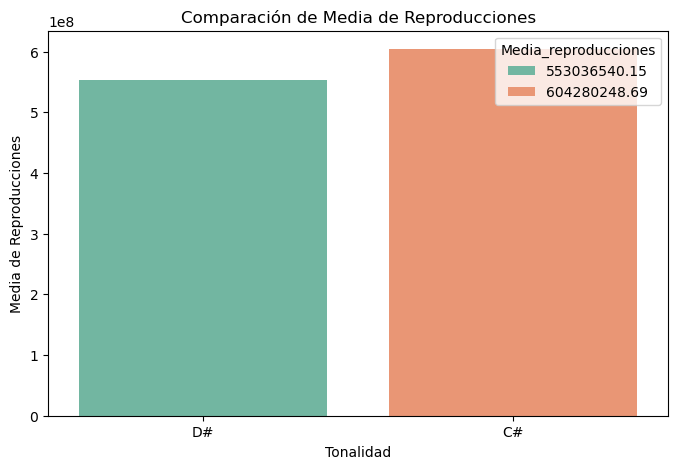

In [131]:
#Comparación de Media de Reproducciones
consulta = [
    {"$match": {"$or": [{"key": "C#"}, {"key": "D#"}]}},
    {"$group": {"_id": "$key", "Media_reproducciones": {"$avg": "$streams"}}},
    {"$project": {"_id": 0, "key": "$_id", "Media_reproducciones": {"$round": ["$Media_reproducciones", 2]}}}
]

resultado = db.Spotify.aggregate(consulta)
df = pd.DataFrame(list(resultado))

# Gráfico de comparación
plt.figure(figsize=(8, 5))
sns.barplot(x="key", y="Media_reproducciones", hue="Media_reproducciones", data=df, palette="Set2")
plt.title('Comparación de Media de Reproducciones')
plt.xlabel('Tonalidad')
plt.ylabel('Media de Reproducciones')
plt.show()

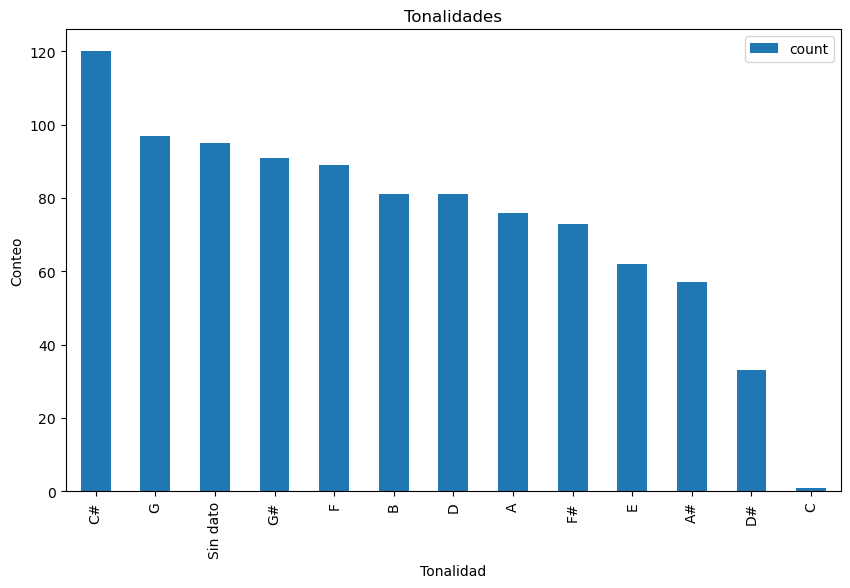

In [112]:
#Tonalidades de canciones
consulta = [
    { "$group": { "_id": "$key", "count": { "$sum": 1 }}},
    { "$project": { "_id": 0, "key": "$_id", "count": 1 }},
    { "$sort": { "count": -1 }}
]

result = db.Spotify.aggregate(consulta)

#print(tonality_counts)
df = pd.DataFrame(list(result))
#grafico 
df.set_index("key", inplace=True)
df.plot(kind="bar", figsize=(10, 6))
plt.title('Tonalidades')
plt.xlabel('Tonalidad')
plt.ylabel('Conteo')
plt.show()

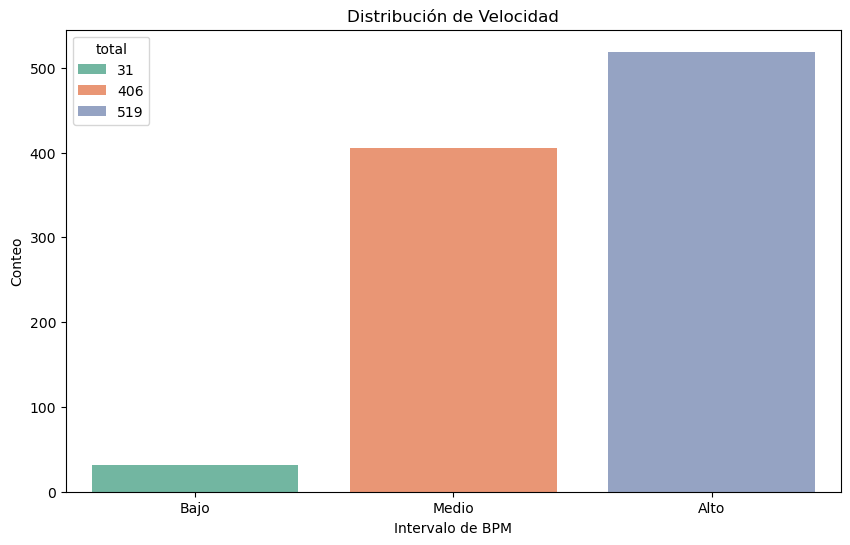

In [120]:
#Distribución de Velocidad por cancion
consulta = [
    {
        "$bucket": {
            "groupBy": "$bpm",
            "boundaries": [0, 80, 120, 360],
            "default": "Otros",
            "output": {"count": {"$sum": 1}}
        }
    },
    {
        "$project": {
            "_id": 0,
            "intervalo": {
                "$switch": {
                    "branches": [
                        {"case": {"$and": [{"$gte": ["$_id", 0]}, {"$lt": ["$_id", 80]}]}, "then": "Bajo"},
                        {"case": {"$and": [{"$gte": ["$_id", 80]}, {"$lt": ["$_id", 120]}]}, "then": "Medio"},
                        {"case": {"$gte": ["$_id", 120]}, "then": "Alto"}
                    ],"default": "Otros"}
            },
            "count": 1
        }
    },
    {
        "$group": {"_id": "$intervalo", "total": {"$sum": "$count"}}
    }
]

result = db.Spotify.aggregate(consulta)

df = pd.DataFrame(list(result))
# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x="_id", y="total", hue='total', data=df, palette='Set2')
plt.title('Distribución de Velocidad')
plt.xlabel('Intervalo de BPM')
plt.ylabel('Conteo')
plt.show()

      platform  Numero_Listas
0      Spotify        4955756
1  Apple Music          64643
2       Deezer          95925


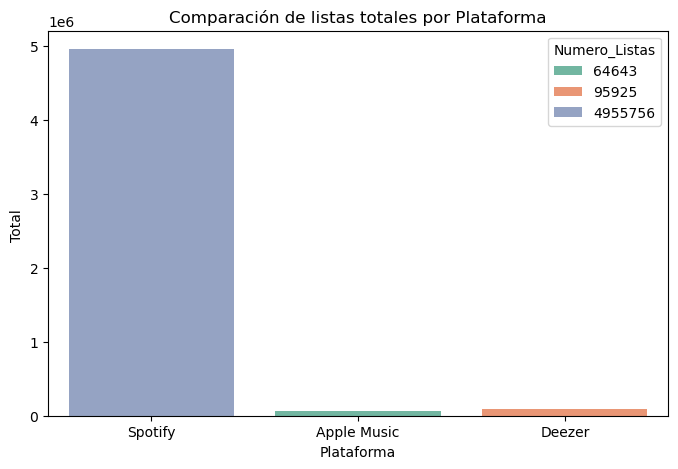

In [150]:
#Comparación de listas totales por Plataforma
consulta = [
    {"$group": {
        "_id": None,
        "SpotyList": {"$sum": "$in_spotify_playlists"},
        "AppleList": {"$sum": "$in_apple_playlists"},
        "DeezerList": {"$sum": "$in_deezer_playlists"}
    }},
    {"$project": {
        "_id": 0,
        "platform": ["Spotify", "Apple Music", "Deezer"],
        "Numero_Listas": ["$SpotyList", "$AppleList", "$DeezerList"]
    }}
]

resultado = db.Spotify.aggregate(consulta)

df = pd.DataFrame(list(resultado)[0])
print(df)
# Gráfico de comparación
plt.figure(figsize=(8, 5))
sns.barplot(x="platform", y="Numero_Listas", hue="Numero_Listas", data=df, palette="Set2")
plt.title('Comparación de listas totales por Plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Total ')
plt.show()

         _id  count  Reproducciones
0  Recientes    907    4.984310e+08
1   Antiguas     49    7.629374e+08


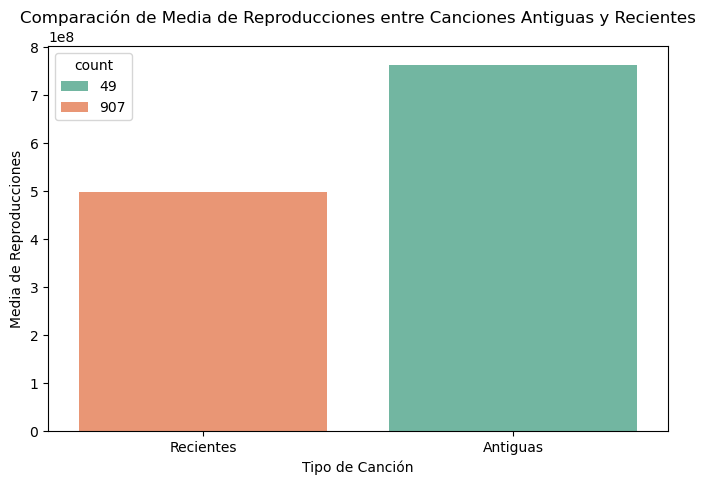

In [157]:
#Comparación de Media de Reproducciones entre Canciones Antiguas y Recientes
consulta = [
    {
        "$group": {
            "_id": {
                "$cond": {
                    "if": {"$lt": ["$released_year", 2000]},
                    "then": "Antiguas",
                    "else": "Recientes"
                }
            },
            "count": {"$sum": 1},
            "Reproducciones": {"$avg": "$streams"}
        }
    }
]

resultado = db.Spotify.aggregate(consulta)
df = pd.DataFrame(list(resultado))
print(df)
# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(x="_id", y="Reproducciones", hue="count", data=df, palette="Set2")
plt.title('Comparación de Media de Reproducciones entre Canciones Antiguas y Recientes')
plt.xlabel('Tipo de Canción')
plt.ylabel('Media de Reproducciones')
plt.show()